<a href="https://colab.research.google.com/github/dettmar/machine-learning/blob/master/MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch, torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [0]:
transforms = [
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
augmentations = [
  #torchvision.transforms.RandomAffine([-90, 90], translate=[0.2, 0.2], scale=[0.5, 0.5], shear=[-10, 10]),
  torchvision.transforms.RandomAffine([-45, 45]),
  torchvision.transforms.RandomAffine([-45, 45], scale=[0.9, 1.1]),
  torchvision.transforms.RandomAffine([0,0], shear=[-45, 45]),
  torchvision.transforms.RandomAffine([-30, 30], scale=[0.9, 1.1], shear=[-45, 45]),
  torchvision.transforms.RandomPerspective(distortion_scale=.5, p=1, interpolation=3)
]
# original untouched
traintransforms = torchvision.transforms.Compose(transforms)
trainset = datasets.MNIST('./data', train=True, download=True, transform=traintransforms)

for augmentation in augmentations:
  traintransforms = torchvision.transforms.Compose([augmentation] + transforms)
  modifiedtrainset = datasets.MNIST('./data', train=True, download=True, transform=traintransforms)
  trainset = torch.utils.data.ConcatDataset([trainset, modifiedtrainset])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=125, shuffle=True)

testtransforms = torchvision.transforms.Compose(transforms)
testset = datasets.MNIST('./data', train=False, transform=testtransforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    log_interval = 200
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, datasetname = "Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(datasetname,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [6]:
model = Net().to(device)
history_train = []
history_test = []
for lr in [0.1, 0.01, 0.001, 0.0001]:
  print("Learning rate:", lr)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)

  for epoch in range(1, 10 + 1):
      train(model, device, trainloader, optimizer, epoch)
      history_test.append(test(model, device, test_loader, "Test"))
      history_train.append(test(model, device, trainloader, "Train"))

Learning rate: 0.1
Train Epoch: 1 [0/360000 (0.0%)]	Loss: 2.298272
Train Epoch: 1 [25000/360000 (6.9%)]	Loss: 0.300703
Train Epoch: 1 [50000/360000 (13.9%)]	Loss: 0.191797
Train Epoch: 1 [75000/360000 (20.8%)]	Loss: 0.097032
Train Epoch: 1 [100000/360000 (27.8%)]	Loss: 0.079423
Train Epoch: 1 [125000/360000 (34.7%)]	Loss: 0.096656
Train Epoch: 1 [150000/360000 (41.7%)]	Loss: 0.161402
Train Epoch: 1 [175000/360000 (48.6%)]	Loss: 0.091698
Train Epoch: 1 [200000/360000 (55.6%)]	Loss: 0.018975
Train Epoch: 1 [225000/360000 (62.5%)]	Loss: 0.091461
Train Epoch: 1 [250000/360000 (69.4%)]	Loss: 0.058985
Train Epoch: 1 [275000/360000 (76.4%)]	Loss: 0.092437
Train Epoch: 1 [300000/360000 (83.3%)]	Loss: 0.099883
Train Epoch: 1 [325000/360000 (90.3%)]	Loss: 0.061512
Train Epoch: 1 [350000/360000 (97.2%)]	Loss: 0.018165

Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

Train set: Average loss: 0.0579, Accuracy: 353527/360000 (98.20%)
Train Epoch: 2 [0/360000 (0.0%)]	Loss: 0.022843
Tra

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(),"./mnist_cnn2.pt")

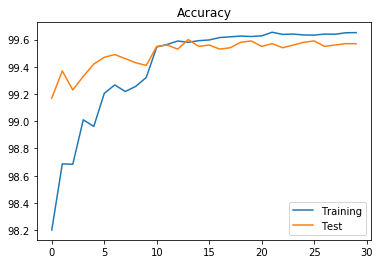

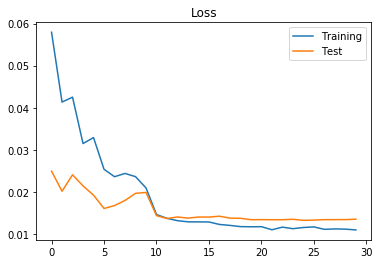

In [17]:
def plotprog(title, traindata, testdata):
  l1, = plt.plot(range(len(traindata)), traindata, label="Training")
  l2, = plt.plot(range(len(testdata)), testdata, label="Test")
  plt.legend(handles=[l1,l2])
  plt.title(title)
  plt.show()

  
plotprog("Accuracy", [t[1]*100 for t in history_train], [t[1]*100 for t in history_test])
plotprog("Loss", [t[0] for t in history_train], [t[0] for t in history_test])

In [0]:
def see(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            matches = pred.eq(target.view_as(pred)).cpu().numpy().flatten()
            pred = pred.cpu().numpy().flatten()[matches == 0]
            target = target.cpu().numpy().flatten()[matches == 0]
            print("pred", pred.shape)
            print("target", target.shape)
            print("matches", matches.shape, (matches == 0).shape)
            imgs = data.cpu().numpy()[:, 0, :, :][matches == 0]
            print("mismatches", (matches == 0).sum())
            for i, img in enumerate(imgs):
              print(i, "prediction", pred[i], "target", target[i], output[i].cpu().numpy())
              plt.imshow(img)
              plt.show()
            #break
            
            #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()


In [0]:
test(model, device, test_loader)
see(model, device, test_loader)

In [0]:
model.